# Notebook de Evaluación de Rendimiento

El objetivo de este Notebook es la comparación de las salidas de los diferentes modelos. Ver que modelo es mejor, así como aciertos y fallos comunes.

Los modelos que se van a evaluar ahora mismo son un TF-IDF + SVM, una Red Neuronal de creación propia y un transformer fine-tuneado (BETO).

Las métricas serán NDCG@4, MAP@4, Overlap@4 para ver como se comportan los rankings.

## 1. Carga de datos

Vamos a cargar archivos coresspondientes a pares en los que las columnas seránn el id del CV, el id de la oferta, un score asociado a ese par y en qué ranking queda.

In [62]:
# Importación de librerías básicas
import os
import sys
import logging
import numpy as np
import pandas as pd

# Configuración de logging para ver mensajes en consola
logging.basicConfig(level=logging.INFO, format='%(levelname)s:%(message)s')

In [63]:
# Carga de los archivos de resultados de los modelos en dataframes

def load_results(file_path):
    """
    Carga los resultados de un archivo CSV en un DataFrame de pandas.
    
    :param file_path: Ruta al archivo CSV que contiene los resultados.
    :return: DataFrame con los resultados cargados.
    """
    if not os.path.exists(file_path):
        logging.error(f"Archivo no encontrado: {file_path}")
        raise FileNotFoundError(f"Archivo no encontrado: {file_path}")
    try:
        df = pd.read_csv(file_path)
        logging.info(f"Resultados cargados desde {file_path}")
        return df
    except Exception as e:
        logging.error(f"Error al cargar los resultados desde {file_path}: {e}")
        raise

# Define rutas relativas a la raíz del proyecto
reports_root = "../reports"
interim_root = "../data/interim"

# Paths de los archivos de resultados
tfidf_path = os.path.join(reports_root, 'rankings_test_tfidf.csv')
red_neuronal_propia_path = os.path.join(reports_root, 'rankings_test_red_neuronal.csv')
beto_path = os.path.join(reports_root, 'rankings_test_beto.csv')
test_path = os.path.join(interim_root, 'dataset_ranking_test.csv')

# Carga los resultados en DataFrames
tfidf_results = load_results(tfidf_path)
red_neuronal_propia_results = load_results(red_neuronal_propia_path)
beto_results = load_results(beto_path)
test_results = load_results(test_path)

INFO:Resultados cargados desde ../reports\rankings_test_tfidf.csv
INFO:Resultados cargados desde ../reports\rankings_test_red_neuronal.csv
INFO:Resultados cargados desde ../reports\rankings_test_beto.csv
INFO:Resultados cargados desde ../data/interim\dataset_ranking_test.csv


In [64]:
def normalize_ranking_df(df, 
                        cv_id_col='cv_id', 
                        offer_id_col='offer_id', 
                        score_col='score', 
                        rank_col='rank'):
    """
    Normaliza un DataFrame de ranking de modelos:
    - Renombra las columnas al estándar.
    - Elimina columnas no necesarias.
    - Si falta la columna 'rank', la crea ordenando por 'score' descendente por cada cv_id.
    
    :param df: DataFrame de entrada
    :param cv_id_col: Nombre de la columna cv_id en el DataFrame original
    :param offer_id_col: Nombre de la columna offer_id en el DataFrame original
    :param score_col: Nombre de la columna de score en el DataFrame original
    :param rank_col: Nombre de la columna de ranking en el DataFrame original (si existe)
    :return: DataFrame normalizado con columnas ['cv_id', 'offer_id', 'score', 'rank']
    """
    cols_rename = {cv_id_col: 'cv_id', offer_id_col: 'offer_id', score_col: 'score', 'score_pred': 'score'}
    if rank_col in df.columns:
        cols_rename[rank_col] = 'rank'
    df = df.rename(columns=cols_rename)
    # Si no existe 'rank', la calculamos (1 = mejor score)
    if 'rank' not in df.columns:
        df['rank'] = df.groupby('cv_id')['score'].rank(ascending=False, method='first').astype(int)
    
    # Nos quedamos solo con las columnas claves
    df = df[['cv_id', 'offer_id', 'score', 'rank']]
    return df


In [65]:
tfidf_results = normalize_ranking_df(tfidf_results,
                                     cv_id_col='cv_id',
                                     offer_id_col='offer_id',
                                     score_col='score',
                                     rank_col='rank')

red_neuronal_propia_results = normalize_ranking_df(red_neuronal_propia_results,
                                                   cv_id_col='cv_id',
                                                   offer_id_col='offer_id',
                                                   score_col='score',
                                                   rank_col='rank')

beto_results = normalize_ranking_df(beto_results,
                                    cv_id_col='cv_id',
                                    offer_id_col='offer_id',
                                    score_col='score',
                                    rank_col='rank')

test_results = normalize_ranking_df(test_results,
                                    cv_id_col='cv_id',
                                    offer_id_col='offer_id',
                                    score_col='score',
                                    rank_col='rank')

## 2. Preprocesamiento

En este caso haremos tests para validar que los datos que obtenemos son consistentes y que no puedan producir problemas en el futuro.

In [66]:
def check_duplicates_and_nulls(df, model_name):
    """
    Comprueba si hay duplicados o valores nulos en el DataFrame.
    """
    if df.duplicated().any():
        logging.warning(f"El DataFrame de {model_name} contiene duplicados.")
    else:
        logging.info(f"El DataFrame de {model_name} no contiene duplicados.")

    if df.isnull().values.any():
        logging.warning(f"El DataFrame de {model_name} contiene valores nulos.")
    else:
        logging.info(f"El DataFrame de {model_name} no contiene valores nulos.")

check_duplicates_and_nulls(tfidf_results, "TF-IDF")
check_duplicates_and_nulls(red_neuronal_propia_results, "Red Neuronal Propia")
check_duplicates_and_nulls(beto_results, "Beto")
check_duplicates_and_nulls(test_results, "Test")


INFO:El DataFrame de TF-IDF no contiene duplicados.
INFO:El DataFrame de TF-IDF no contiene valores nulos.
INFO:El DataFrame de Red Neuronal Propia no contiene duplicados.
INFO:El DataFrame de Red Neuronal Propia no contiene valores nulos.
INFO:El DataFrame de Beto no contiene duplicados.
INFO:El DataFrame de Beto no contiene valores nulos.
INFO:El DataFrame de Test no contiene duplicados.
INFO:El DataFrame de Test no contiene valores nulos.


In [67]:
def check_and_fix_cv_id_format(df, model_name):
    """
    Comprueba y corrige que todas las columnas cv_id tengan el formato correcto: cvXX.pdf.
    Si encuentra cvXX sin .pdf, lo corrige automáticamente.
    """
    mask_incorrect = ~df['cv_id'].str.match(r'^cv\d{2}\.pdf$')
    if mask_incorrect.any():
        logging.warning(f"El DataFrame de {model_name} contiene cv_ids con formato incorrecto. Corrigiendo...")
        mask_needs_pdf = df.loc[mask_incorrect, 'cv_id'].str.match(r'^cv\d{2}$')
        df.loc[mask_incorrect & mask_needs_pdf, 'cv_id'] = df.loc[mask_incorrect & mask_needs_pdf, 'cv_id'] + ".pdf"
        still_wrong = ~df['cv_id'].str.match(r'^cv\d{2}\.pdf$')
        if still_wrong.any():
            logging.error(f"Algunos cv_id de {model_name} siguen con formato incorrecto tras la corrección:")
            logging.error(df.loc[still_wrong, 'cv_id'])
        else:
            logging.info(f"Todos los cv_ids de {model_name} están ahora en el formato correcto.")
    else:
        logging.info(f"El DataFrame de {model_name} tiene todos los cv_ids en el formato correcto.")

check_and_fix_cv_id_format(tfidf_results, "TF-IDF")
check_and_fix_cv_id_format(red_neuronal_propia_results, "Red Neuronal Propia")
check_and_fix_cv_id_format(beto_results, "Beto")
check_and_fix_cv_id_format(test_results, "Test")


INFO:El DataFrame de TF-IDF tiene todos los cv_ids en el formato correcto.
INFO:El DataFrame de Red Neuronal Propia tiene todos los cv_ids en el formato correcto.
INFO:Todos los cv_ids de Beto están ahora en el formato correcto.
INFO:El DataFrame de Test tiene todos los cv_ids en el formato correcto.


In [68]:
offer_id_equivalence = {
    # Ciencia de datos
    "0_Ciencia_de_datos": "0_Ciencia_de_datos",
    "Ciencia_de_datos_España.txt_0": "0_Ciencia_de_datos",
    "1_Ciencia_de_datos": "1_Ciencia_de_datos",
    "Ciencia_de_datos_España.txt_1": "1_Ciencia_de_datos",
    "2_Ciencia_de_datos": "2_Ciencia_de_datos",
    "Ciencia_de_datos_España.txt_2": "2_Ciencia_de_datos",
    "3_Ciencia_de_datos": "3_Ciencia_de_datos",
    "Ciencia_de_datos_España.txt_3": "3_Ciencia_de_datos",
    "4_Ciencia_de_datos": "4_Ciencia_de_datos",
    "Ciencia_de_datos_España.txt_4": "4_Ciencia_de_datos",
    "0_cdatos": "0_Ciencia_de_datos",
    "1_cdatos": "1_Ciencia_de_datos",
    "2_cdatos": "2_Ciencia_de_datos",
    "3_cdatos": "3_Ciencia_de_datos",
    "4_cdatos": "4_Ciencia_de_datos",

    # Ingeniero de datos
    "0_Ingeniero_de_datos": "0_Ingeniero_de_datos",
    "Ingeniero_de_datos_España.txt_0": "0_Ingeniero_de_datos",
    "1_Ingeniero_de_datos": "1_Ingeniero_de_datos",
    "Ingeniero_de_datos_España.txt_1": "1_Ingeniero_de_datos",
    "2_Ingeniero_de_datos": "2_Ingeniero_de_datos",
    "Ingeniero_de_datos_España.txt_2": "2_Ingeniero_de_datos",
    "3_Ingeniero_de_datos": "3_Ingeniero_de_datos",
    "Ingeniero_de_datos_España.txt_3": "3_Ingeniero_de_datos",
    "4_Ingeniero_de_datos": "4_Ingeniero_de_datos",
    "Ingeniero_de_datos_España.txt_4": "4_Ingeniero_de_datos",
    "0_ingdatos": "0_Ingeniero_de_datos",
    "1_ingdatos": "1_Ingeniero_de_datos",
    "2_ingdatos": "2_Ingeniero_de_datos",
    "3_ingdatos": "3_Ingeniero_de_datos",
    "4_ingdatos": "4_Ingeniero_de_datos",

    # Jurista
    "0_Jurista": "0_Jurista",
    "Jurista_Málaga.txt_0": "0_Jurista",
    "1_Jurista": "1_Jurista",
    "Jurista_Málaga.txt_1": "1_Jurista",
    "2_Jurista": "2_Jurista",
    "Jurista_Málaga.txt_2": "2_Jurista",
    "3_Jurista": "3_Jurista",
    "Jurista_Málaga.txt_3": "3_Jurista",
    "4_Jurista": "4_Jurista",
    "Jurista_Málaga.txt_4": "4_Jurista",
    "0_jurista": "0_Jurista",
    "1_jurista": "1_Jurista",
    "2_jurista": "2_Jurista",
    "3_jurista": "3_Jurista",
    "4_jurista": "4_Jurista",

    # Traductor de inglés
    "0_Traductor_de_inglés": "0_Traductor_de_inglés",
    "Traductor_de_inglés_Málaga.txt_0": "0_Traductor_de_inglés",
    "1_Traductor_de_inglés": "1_Traductor_de_inglés",
    "Traductor_de_inglés_Málaga.txt_1": "1_Traductor_de_inglés",
    "2_Traductor_de_inglés": "2_Traductor_de_inglés",
    "Traductor_de_inglés_Málaga.txt_2": "2_Traductor_de_inglés",
    "3_Traductor_de_inglés": "3_Traductor_de_inglés",
    "Traductor_de_inglés_Málaga.txt_3": "3_Traductor_de_inglés",
    "0_traductor": "0_Traductor_de_inglés",
    "1_traductor": "1_Traductor_de_inglés",
    "2_traductor": "2_Traductor_de_inglés",
    "3_traductor": "3_Traductor_de_inglés",
}


In [69]:
import re

def check_and_fix_offer_id_format(df, model_name, equivalence_dict=None, max_iter=2):
    """
    Aplica diccionario de equivalencias y reglas automáticas varias veces hasta que
    todos los offer_id estén normalizados o se alcance el máximo de iteraciones.
    """
    pattern_correct = r'^\d+_[A-Za-z0-9_íéáóúñÍÉÁÓÚÑ]+$'
    changed = True
    iter_count = 0

    while changed and iter_count < max_iter:
        changed = False
        if equivalence_dict is not None:
            offer_id_before = df['offer_id'].copy()
            df['offer_id'] = df['offer_id'].apply(lambda oid: equivalence_dict.get(oid, oid))
            if not offer_id_before.equals(df['offer_id']):
                changed = True

        mask_incorrect = ~df['offer_id'].str.match(pattern_correct)
        if mask_incorrect.any():
            def try_fix(oid):
                m = re.match(r'^([A-Za-z_]+)_(\d+)$', oid)
                if m:
                    return f"{m.group(2)}_{m.group(1)}"
                m = re.match(r'^([A-Za-z_]+)\.txt_(\d+)$', oid)
                if m:
                    return f"{m.group(2)}_{m.group(1)}"
                m = re.match(r'^([A-Za-z_]+)_(\d+)\.txt$', oid)
                if m:
                    return f"{m.group(2)}_{m.group(1)}"
                m = re.match(r'^([A-Za-z_]+)$', oid)
                if m:
                    return f"0_{m.group(1)}"
                if re.match(pattern_correct, oid):
                    return oid
                return oid
            offer_id_before = df.loc[mask_incorrect, 'offer_id'].copy()
            df.loc[mask_incorrect, 'offer_id'] = df.loc[mask_incorrect, 'offer_id'].apply(try_fix)
            if not offer_id_before.equals(df.loc[mask_incorrect, 'offer_id']):
                changed = True

        iter_count += 1

    mask_incorrect = ~df['offer_id'].str.match(pattern_correct)
    if mask_incorrect.any():
        logging.error(f"Tras {max_iter} iteraciones, algunos offer_id de {model_name} siguen con formato incorrecto:")
        logging.error(df.loc[mask_incorrect, 'offer_id'].unique())
    else:
        logging.info(f"Todos los offer_ids de {model_name} están ahora en el formato correcto.")

for df, name in zip(
    [tfidf_results, red_neuronal_propia_results, beto_results, test_results],
    ["TF-IDF", "Red Neuronal Propia", "Beto", "Test"]
):
    check_and_fix_offer_id_format(df, name, equivalence_dict=offer_id_equivalence, max_iter=3)


INFO:Todos los offer_ids de TF-IDF están ahora en el formato correcto.
INFO:Todos los offer_ids de Red Neuronal Propia están ahora en el formato correcto.
INFO:Todos los offer_ids de Beto están ahora en el formato correcto.
INFO:Todos los offer_ids de Test están ahora en el formato correcto.


In [70]:
def convert_data_types(df):
    """
    Convierte los tipos de datos de las columnas del DataFrame:
    - cv_id y offer_id a string
    - score a float
    - rank a int (permite nulos)
    """
    df['cv_id'] = df['cv_id'].astype(str)
    df['offer_id'] = df['offer_id'].astype(str)
    df['score'] = pd.to_numeric(df['score'], errors='coerce')
    df['rank'] = pd.to_numeric(df['rank'], errors='coerce').astype('Int64')
    return df

tfidf_results = convert_data_types(tfidf_results)
red_neuronal_propia_results = convert_data_types(red_neuronal_propia_results)
beto_results = convert_data_types(beto_results)
test_results = convert_data_types(test_results)


In [71]:
def print_offer_id_diff(*dfs, names=None):
    sets = [set(df['offer_id']) for df in dfs]
    names = names or [f"df{i+1}" for i in range(len(dfs))]
    base_set = sets[0]
    base_name = names[0]
    for idx, (s, n) in enumerate(zip(sets[1:], names[1:])):
        only_in_base = base_set - s
        only_in_other = s - base_set
        print(f"Comparando {base_name} vs {n}:")
        if only_in_base:
            print(f"  Solo en {base_name}:", sorted(only_in_base))
        if only_in_other:
            print(f"  Solo en {n}:", sorted(only_in_other))
        if not only_in_base and not only_in_other:
            print("  ¡Conjuntos idénticos!\n")

print_offer_id_diff(
    tfidf_results, red_neuronal_propia_results, beto_results, test_results,
    names=["TF-IDF", "Red Neuronal Propia", "Beto", "Test"]
)


Comparando TF-IDF vs Red Neuronal Propia:
  ¡Conjuntos idénticos!

Comparando TF-IDF vs Beto:
  ¡Conjuntos idénticos!

Comparando TF-IDF vs Test:
  ¡Conjuntos idénticos!



In [72]:
def check_integrity_of_comparison(*dfs):
    """
    Comprueba que todos los DataFrames tienen el mismo conjunto de cv_id y offer_id.
    """
    cv_ids = set(dfs[0]['cv_id'])
    offer_ids = set(dfs[0]['offer_id'])

    for df in dfs[1:]:
        if set(df['cv_id']) != cv_ids:
            logging.error("Discrepancia en cv_id entre los DataFrames.")
            return False
        if set(df['offer_id']) != offer_ids:
            logging.error("Discrepancia en offer_id entre los DataFrames.")
            return False

    logging.info("Todos los DataFrames tienen el mismo conjunto de cv_id y offer_id.")
    return True

if not check_integrity_of_comparison(tfidf_results, red_neuronal_propia_results, beto_results, test_results):
    logging.error("Los DataFrames no son consistentes. Revisa los datos.")
    sys.exit(1)


INFO:Todos los DataFrames tienen el mismo conjunto de cv_id y offer_id.


In [73]:
def summarize_results(df, model_name):
    """
    Muestra un resumen estadístico de los scores y ranks del DataFrame.
    """
    logging.info(f"Resumen de resultados para {model_name}:")
    logging.info(f"Scores:\n{df['score'].describe()}")
    logging.info(f"Ranks:\n{df['rank'].describe()}")

summarize_results(tfidf_results, "TF-IDF")
summarize_results(red_neuronal_propia_results, "Red Neuronal Propia")
summarize_results(beto_results, "Beto")
summarize_results(test_results, "Test")


INFO:Resumen de resultados para TF-IDF:
INFO:Scores:
count    285.000000
mean       0.210291
std        0.133388
min        0.021932
25%        0.109251
50%        0.171209
75%        0.290127
max        0.681822
Name: score, dtype: float64
INFO:Ranks:
count      285.0
mean        10.0
std      5.48686
min          1.0
25%          5.0
50%         10.0
75%         15.0
max         19.0
Name: rank, dtype: Float64
INFO:Resumen de resultados para Red Neuronal Propia:
INFO:Scores:
count    285.000000
mean       0.265594
std        0.337109
min        0.054751
25%        0.054766
50%        0.055778
75%        0.731281
max        0.848193
Name: score, dtype: float64
INFO:Ranks:
count      285.0
mean        10.0
std      5.48686
min          1.0
25%          5.0
50%         10.0
75%         15.0
max         19.0
Name: rank, dtype: Float64
INFO:Resumen de resultados para Beto:
INFO:Scores:
count    285.000000
mean       0.194898
std        0.131402
min        0.048929
25%        0.104346
50% 

## 3. Definición e Implementación de Métricas de Evaluación

Las métricas de ranking que vamos a medir son muy importantes, ya que nos proporcionan una visión cuantitativa sobre la calidad del sistema de recomendación y nos permiten comparar diferentes modelos de manera objetiva.

A continuación se describen las métricas que utilizaremos:

- NDCG@4 (Normalized Discounted Cumulative Gain @4):
Evalúa la ganancia acumulada de los resultados hasta la posición 4, aplicando un descuento logarítmico según la posición. El resultado está normalizado respecto a la mejor clasificación posible.

    - ¿Por qué es importante?
Mide tanto la relevancia como el orden de las recomendaciones en el top-4, reflejando escenarios reales donde el usuario solo ve las primeras opciones.

- MAP@4 (Mean Average Precision @4):
Calcula la precisión promedio de las ofertas relevantes encontradas en las primeras 4 posiciones, y promedia sobre todos los CV.

    - ¿Por qué es importante?
Da una idea clara de cuántas de las ofertas realmente relevantes aparecen entre las primeras recomendaciones.

- Overlap@4:
Mide cuántas ofertas coinciden en el top-4 entre diferentes modelos o respecto al sistema ideal.

    - ¿Por qué es importante?
Permite ver si los modelos llegan a recomendar los mismos puestos en el top del ranking, útil para comparar divergencia o solapamiento entre modelos.

- Kendall-τ / Spearman-ρ:
Son coeficientes de correlación que miden el grado de acuerdo entre dos rankings completos.

    - Kendall-τ: Cuenta pares de elementos ordenados igual/diferente en dos listas.

    - Spearman-ρ: Correlación de rangos, sensible a diferencias en las posiciones de los elementos.

    - ¿Por qué son importantes?
Dan una perspectiva global del parecido entre rankings completos, no solo del top-4.

In [74]:
import numpy as np
from scipy.stats import kendalltau, spearmanr

In [75]:
# NDCG@k: compara la relevancia del modelo frente al test
def ndcg_at_k(model_df, test_df, k=4):
    """
    Calcula el NDCG@k comparando los rankings del modelo contra el test para cada cv_id.
    Asume que en test_df['score'] se encuentra la relevancia real (por ejemplo, binaria).
    """
    def dcg(rels):
        return np.sum(rels / np.log2(np.arange(2, len(rels) + 2)))
    
    def idcg(rels):
        sorted_rels = np.sort(rels)[::-1]
        return dcg(sorted_rels)
    
    ndcgs = []
    for cv_id in model_df['cv_id'].unique():
        model_top = model_df[model_df['cv_id'] == cv_id].sort_values('rank')['offer_id'].head(k)
        rels = []
        test_cvs = test_df[test_df['cv_id'] == cv_id].set_index('offer_id')
        for oid in model_top:
            rels.append(test_cvs.loc[oid, 'score'] if oid in test_cvs.index else 0)
        if len(rels) < k:
            continue
        dcg_value = dcg(np.array(rels))
        idcg_value = idcg(np.array(rels))
        ndcg = dcg_value / idcg_value if idcg_value > 0 else 0
        ndcgs.append(ndcg)
    return float(np.mean(ndcgs)) if ndcgs else 0.0

In [76]:
# MAP@k: calcula la media de average precision en el top-k del modelo respecto a la relevancia del test
def map_at_k(model_df, test_df, k=4):
    """
    Calcula el MAP@k comparando el top-k del modelo frente a la relevancia real en el test.
    """
    aps = []
    for cv_id in model_df['cv_id'].unique():
        model_top = model_df[model_df['cv_id'] == cv_id].sort_values('rank')['offer_id'].head(k)
        test_cvs = test_df[test_df['cv_id'] == cv_id].set_index('offer_id')
        relevant = [test_cvs.loc[oid, 'score'] if oid in test_cvs.index else 0 for oid in model_top]
        num_relevant = sum([rel > 0 for rel in relevant])
        if num_relevant == 0:
            aps.append(0.0)
            continue
        precisions = []
        num_hits = 0
        for i, rel in enumerate(relevant):
            if rel > 0:
                num_hits += 1
                precisions.append(num_hits / (i + 1))
        aps.append(np.mean(precisions) if precisions else 0.0)
    return float(np.mean(aps)) if aps else 0.0

In [77]:
# Overlap@k: mide el solapamiento entre los top-k del modelo y el test
def overlap_at_k(model_df, test_df, k=4):
    overlaps = []
    for cv_id in model_df['cv_id'].unique():
        model_top = model_df[model_df['cv_id'] == cv_id].sort_values('rank')['offer_id'].head(k)
        test_top = test_df[test_df['cv_id'] == cv_id].sort_values('rank')['offer_id'].head(k)
        overlap = len(set(model_top) & set(test_top))
        overlaps.append(overlap)
    return float(np.mean(overlaps)) if overlaps else 0.0

In [78]:
# Kendall-τ: correlación entre el orden del modelo y el orden real del test para cada cv_id
def kendall_tau_vs_ref(model_df, test_df):
    tau_values = []
    for cv_id in model_df['cv_id'].unique():
        m = model_df[model_df['cv_id'] == cv_id].set_index('offer_id')
        t = test_df[test_df['cv_id'] == cv_id].set_index('offer_id')
        common_ids = list(set(m.index) & set(t.index))
        if len(common_ids) < 2:
            continue
        # Ordena ambos rankings según offer_id común
        m_ranks = m.loc[common_ids]['rank']
        t_ranks = t.loc[common_ids]['rank']
        tau, _ = kendalltau(m_ranks, t_ranks)
        tau_values.append(tau)
    return float(np.nanmean(tau_values)) if tau_values else 0.0

# Spearman-ρ: igual que arriba pero para Spearman
def spearman_rho_vs_ref(model_df, test_df):
    rho_values = []
    for cv_id in model_df['cv_id'].unique():
        m = model_df[model_df['cv_id'] == cv_id].set_index('offer_id')
        t = test_df[test_df['cv_id'] == cv_id].set_index('offer_id')
        common_ids = list(set(m.index) & set(t.index))
        if len(common_ids) < 2:
            continue
        m_ranks = m.loc[common_ids]['rank']
        t_ranks = t.loc[common_ids]['rank']
        rho, _ = spearmanr(m_ranks, t_ranks)
        rho_values.append(rho)
    return float(np.nanmean(rho_values)) if rho_values else 0.0

## 4. Evaluación Cuantitativa y Comparación de modelos

Las métricas de evaluación se calcularán para cada modelo, tanto a nivel global (promediando sobre todos los CVs) como a nivel individual por CV. Los resultados se mostrarán en tablas comparativas, donde cada fila corresponde a un modelo y cada columna a una métrica.

Además, se podrán visualizar gráficos de barras y/o heatmaps para comparar de forma visual el desempeño entre modelos.

In [79]:
metrics = []

metrics.append({
    "Modelo": "TF-IDF",
    "NDCG@4": ndcg_at_k(tfidf_results, test_results, k=4),
    "MAP@4": map_at_k(tfidf_results, test_results, k=4),
    "Overlap@4": overlap_at_k(tfidf_results, test_results, k=4),
    "Kendall-τ": kendall_tau_vs_ref(tfidf_results, test_results),
    "Spearman-ρ": spearman_rho_vs_ref(tfidf_results, test_results)
})

metrics.append({
    "Modelo": "Red Neuronal Propia",
    "NDCG@4": ndcg_at_k(red_neuronal_propia_results, test_results, k=4),
    "MAP@4": map_at_k(red_neuronal_propia_results, test_results, k=4),
    "Overlap@4": overlap_at_k(red_neuronal_propia_results, test_results, k=4),
    "Kendall-τ": kendall_tau_vs_ref(red_neuronal_propia_results, test_results),
    "Spearman-ρ": spearman_rho_vs_ref(red_neuronal_propia_results, test_results)
})

metrics.append({
    "Modelo": "Beto",
    "NDCG@4": ndcg_at_k(beto_results, test_results, k=4),
    "MAP@4": map_at_k(beto_results, test_results, k=4),
    "Overlap@4": overlap_at_k(beto_results, test_results, k=4),
    "Kendall-τ": kendall_tau_vs_ref(beto_results, test_results),
    "Spearman-ρ": spearman_rho_vs_ref(beto_results, test_results)
})


In [80]:
# Mostrar tablas resumen comparando los resultados de cada modelo (por ejemplo, DataFrame pandas o tablas con print())

metrics_df = pd.DataFrame(metrics)
print("\nResumen de métricas de rendimiento:")
print(metrics_df.to_string(index=False))


Resumen de métricas de rendimiento:
             Modelo   NDCG@4    MAP@4  Overlap@4  Kendall-τ  Spearman-ρ
             TF-IDF 0.747300 0.724074   1.266667   0.247563    0.319181
Red Neuronal Propia 0.600000 0.600000   1.400000   0.130604    0.177778
               Beto 0.605282 0.611111   0.933333   0.026121    0.025380


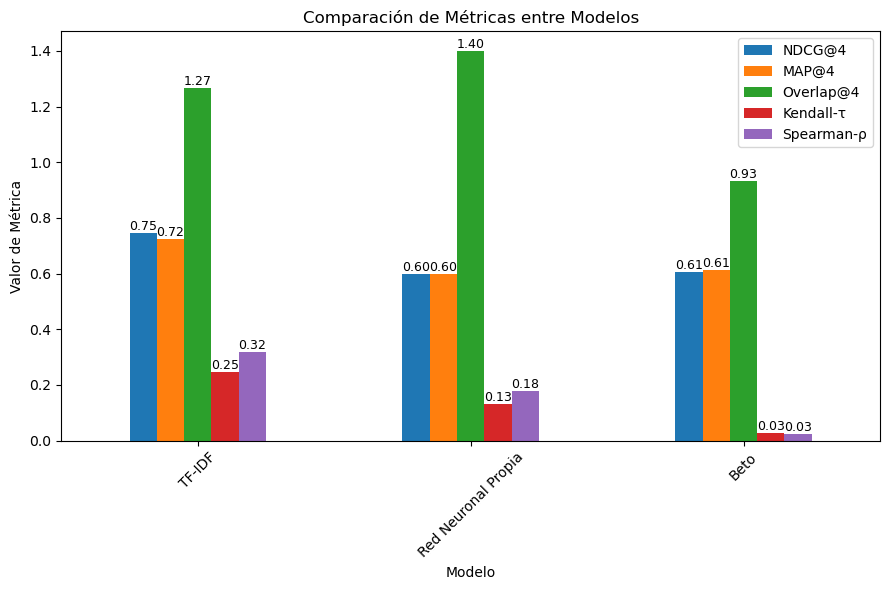

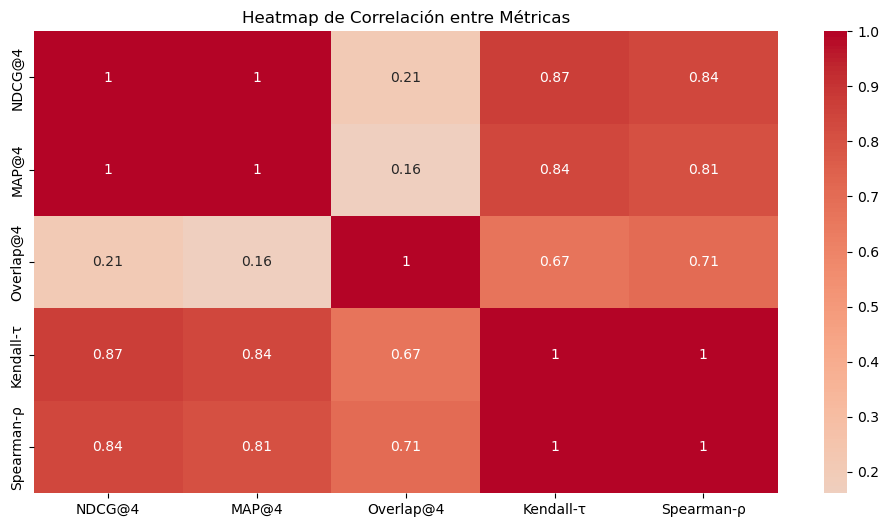

In [ ]:
# Visualizaciones rápidas

import matplotlib.pyplot as plt

# Configuración de la gráfica
plt.figure(figsize=(9, 6))
ax = metrics_df.set_index("Modelo").plot(kind="bar", ax=plt.gca())

# Añade valores encima de cada barra
for c in ax.containers:
    ax.bar_label(c, fmt="%.2f", fontsize=9)

plt.title("Comparación de Métricas entre Modelos")
plt.ylabel("Valor de Métrica")
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# Heatmaps si se desea analizar la distribución
import seaborn as sns

# Configuración del heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(metrics_df.set_index("Modelo").corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Heatmap de Correlación entre Métricas")
plt.show()

**Interpretación de Resultados y Comparativa de Modelos**
Los resultados de las métricas de rendimiento muestran que, aunque ninguno de los modelos alcanza un rendimiento perfecto, todos logran cierto nivel de éxito identificando ofertas relevantes para los CV en el top-4. Destacan los siguientes puntos:

- TF-IDF obtiene los valores más altos de NDCG@4 (0.75) y MAP@4 (0.72), lo que indica que, en promedio, posiciona mejor las ofertas más relevantes en los primeros puestos.

- Red Neuronal Propia y Beto presentan valores similares, aunque algo inferiores, con NDCG@4 y MAP@4 en torno a 0.60. Esto muestra que estos modelos logran un ranking aceptable, pero no superan al baseline TF-IDF en este conjunto.

- Overlap@4 oscila entre 0.93 y 1.40, lo que sugiere que, de media, entre 1 y 1.4 ofertas del top-4 coinciden entre modelos y la referencia, existiendo divergencia en las primeras recomendaciones.

- Kendall-τ y Spearman-ρ muestran correlaciones positivas pero bajas (máximo ~0.25), lo que indica que aunque hay cierta alineación en el ranking global, la concordancia en el orden completo de las ofertas es limitada. Esto es habitual en sistemas donde solo se optimiza por el top del ranking.

- El heatmap de correlación entre métricas confirma que NDCG@4 y MAP@4 están fuertemente relacionadas, mientras que Overlap@4 y las correlaciones globales tienen menor relación directa.

**Conclusión**:
El modelo TF-IDF, a pesar de su simplicidad, se comporta de forma competitiva en este escenario concreto, posicionando mejor las ofertas relevantes en el top-4. Las arquitecturas avanzadas (Red Neuronal Propia y Beto) ofrecen resultados consistentes, pero no logran superar claramente al baseline. Sería interesante analizar los casos individuales donde los modelos divergen y explorar posibles mejoras, como el uso de embeddings más robustos o el ajuste fino de hiperparámetros.

## 6. Comparación detallada entre modelos

En esta sección analizamos las diferencias entre modelos, no solo a nivel global, sino también identificando casos donde los modelos divergen en sus recomendaciones top-4.

In [84]:
# Crea una tabla con el Overlap@4 entre cada modelo y el test para cada CV
def overlap_at_k_per_cv(model_df, test_df, k=4):
    overlaps = []
    for cv_id in model_df['cv_id'].unique():
        model_top = model_df[model_df['cv_id'] == cv_id].sort_values('rank')['offer_id'].head(k)
        test_top = test_df[test_df['cv_id'] == cv_id].sort_values('rank')['offer_id'].head(k)
        overlap = len(set(model_top) & set(test_top))
        overlaps.append({"cv_id": cv_id, "overlap@4": overlap})
    return pd.DataFrame(overlaps)

overlap_tfidf = overlap_at_k_per_cv(tfidf_results, test_results, k=4)
overlap_rnp = overlap_at_k_per_cv(red_neuronal_propia_results, test_results, k=4)
overlap_beto = overlap_at_k_per_cv(beto_results, test_results, k=4)

# Junta los resultados en una tabla
overlap_per_cv = overlap_tfidf.rename(columns={"overlap@4": "TF-IDF"}).merge(
    overlap_rnp.rename(columns={"overlap@4": "Red Neuronal Propia"}), on="cv_id"
).merge(
    overlap_beto.rename(columns={"overlap@4": "Beto"}), on="cv_id"
)
print("\nTabla de Overlap@4 por CV:")
print(overlap_per_cv.to_string(index=False))



Tabla de Overlap@4 por CV:
   cv_id  TF-IDF  Red Neuronal Propia  Beto
cv00.pdf       3                    4     0
cv01.pdf       0                    0     0
cv02.pdf       0                    4     0
cv03.pdf       1                    4     0
cv04.pdf       0                    0     1
cv05.pdf       2                    3     1
cv06.pdf       0                    0     1
cv07.pdf       1                    3     0
cv08.pdf       0                    0     1
cv09.pdf       3                    0     3
cv10.pdf       3                    0     3
cv11.pdf       3                    0     3
cv12.pdf       3                    3     0
cv13.pdf       0                    0     0
cv14.pdf       0                    0     1


**Análisis breve de Overlap@4 por CV**

La tabla muestra una gran variabilidad en el solapamiento del top-4 entre modelos y el test según el CV. Muchos CVs tienen Overlap@4 muy bajo (incluso 0), lo que indica que las recomendaciones de los modelos suelen divergir del ideal para varios perfiles.
Solo en unos pocos casos (por ejemplo, cv00.pdf, cv09.pdf, cv10.pdf, cv11.pdf, cv12.pdf) algún modelo logra un alto solapamiento, pero no de forma consistente.
Esto resalta que ningún modelo acierta siempre y que existen perfiles especialmente difíciles de recomendar correctamente.